# Attribute Importance for Concept Drift
Steps:
1. Identify change-points in process
2. For each chage-point, for each feature evaluate the change in distribution of the feature
3. merge results into feature ranking

## Setup

In [1]:
# imports
import pm4py
import helper
import pandas as pd
import numpy as np
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

In [2]:
# settings

# data settings
dataset = 'bpi_challenge_2013_incidents'

# change-point detection settings
change_point_detection_approach = 'pert'
change_point_features = 'directly_follows'
# TODO need window size?

# change-point explanation settings
window_size = 10 # in days
window_offset = 0
categorical_variables_test = 'chi-squared'
continuous_variables_test = 'kolmogorov-smirnov'

In [3]:
# import log
log = helper.get_log(dataset)

C:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|████████████████████████████████████████████| 7554/7554 [00:08<00:00, 901.12it/s]


In [4]:
from concept_drift import features
from concept_drift import windows
from concept_drift import statistical_tests

In [5]:
features.get_bi_directional_relationship_type_counts(log)

,followed_by_s,followed_by_n,followed_by_a,preceded_by_s,preceded_by_n,preceded_by_a
Accepted,4,0,0,4,0,0
Completed,4,0,0,4,0,0
Queued,4,0,0,3,1,0
Unmatched,2,2,0,3,1,0


In [6]:
window_size = 30
log_windows = windows.get_log_windows(log, window_size, window_offset=5)
pass

In [7]:
# get features for each window
feature_windows = [] 
for window_start, (log_window_a, log_window_b) in log_windows:
    # TODO add option to merge features
    # features_window_a = features.get_bi_directional_relationship_type_counts(log_window_a)
    # features_window_b = features.get_bi_directional_relationship_type_counts(log_window_b)
    
    features_window_a = features.get_relational_entropy(log_window_a)
    features_window_b = features.get_relational_entropy(log_window_b)
    
    feature_windows.append((window_start, (features_window_a, features_window_b)))

In [8]:
# perform statistical test for each window pairing
test_results = []
for window_start, (features_window_a, features_window_b) in feature_windows:
    test_result = statistical_tests.test_kolmogorov_smirnov(features_window_a, features_window_b)
    test_results.append((window_start, test_result))

In [9]:
p_values = [(time, test_result.pvalue) for time, test_result in test_results]

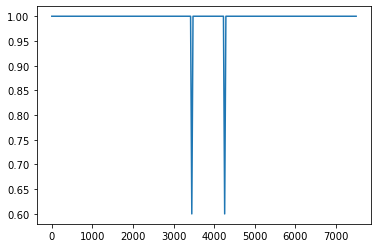

In [10]:
# plot the p values
import matplotlib.pyplot as plt
x_y_data = zip(*p_values)
plt.plot(*x_y_data)
plt.show()

In [11]:
# any point is a changepoint if the p-value was significant (<0.05)
change_points = {}
for time, p_value in p_values:
    if p_value < 0.05:
        change_points[time] = p_value
display(change_points)

{}

In [6]:
features.get_relational_entropy(log, direction='preceded_by')

Completed    0.000000
Accepted     0.000000
Queued       0.811278
Unmatched    0.811278
dtype: float64

In [7]:
activity_occurences = features.get_activity_occurence_counts(log)
display(activity_occurences)
causality_counts = features.get_causality_counts(log)
display(causality_counts)
sna_relationships = features.get_sna_relationships(log)
display(sna_relationships)
relationship_type_counts = features.get_relationship_type_counts(log)
display(relationship_type_counts)
re = features.get_relational_entropy(log)
display(re)

Accepted     40117
Queued       11544
Completed    13867
Unmatched        5
dtype: int64

,Accepted,Queued,Completed,Unmatched
Accepted,195211,60194,80657,22
Queued,74741,22684,24340,4
Completed,4485,1346,7382,6
Unmatched,11,0,10,0


,Accepted,Queued,Completed,Unmatched
Accepted,s,s,s,s
Queued,s,s,s,s
Completed,s,s,s,s
Unmatched,s,n,s,n


,s,n,a
Accepted,4,0,0
Queued,4,0,0
Completed,4,0,0
Unmatched,2,2,0


Accepted     0.0
Queued       0.0
Completed    0.0
Unmatched    1.0
dtype: float64

In [8]:
fake_log = [1, 2, 3, 4, 5, 6]

In [17]:
start = 0
window_size = 2
window_offset = window_size

window_a_start = start
window_a_end = window_a_start + window_size
window_b_start = window_a_start + window_offset
window_b_end = window_b_start + window_size

In [20]:
fake_log[window_b_start:window_b_end]

[3, 4]

## Detect Change-Points

In [20]:
window_size = datetime.timedelta(10, 0, 0) # set window size to 10 days
windows = get_windows(log, window_size)
pass

In [21]:
window_a = windows[0][0]

In [22]:
def get_directy_follows_relationships(log):
    # get the directly follows relationships
    dfg = dfg_discovery.apply(log)
    
    feature_results = {}
    for activity_tuple, count in dfg.items():
        feature_results[str(activity_tuple)] = count

    return feature_results
    
get_directy_follows_relationships(window_a.log)
pass

In [44]:
def _get_sna_dataframe(sna_dict):
    return pd.DataFrame().from_dict(sna_dict, orient='index')

In [60]:
def _get_relation_type_count_df(sna_dataframe):
    activity_rc = {}
    for i, row in sna_dataframe.iterrows():
        # count sometimes, always and never
        activity_rc[i] = row.value_counts().to_dict()
        
        if 'n' not in activity_rc[i]:
            activity_rc[i]['n'] = 0
        
        if 'a' not in activity_rc[i]:
            activity_rc[i]['a'] = 0
            
        if 's' not in activity_rc[i]:
            activity_rc[i]['s'] = 0
    
    return pd.DataFrame().from_dict(activity_rc, orient='index')

In [77]:
def _get_re(relation_type_count_df):
    """Get the relational entropy for a relation type count dataframe.
    """
    activity_count = len(relation_type_count_df.index)
    
    activity_relation_entropy = {}
    
    for activity, row in relation_type_count_df.iterrows():
        # get count for each relation type
        ca = row['a']
        cs = row['s']
        cn = row['n']
        
        # get probability for each relation type
        pa = ca / activity_count
        ps = cs / activity_count
        pn = cn / activity_count
        
        entropy = 0
        for p in [pa, ps, pn]:
            if p != 0:
                entropy += -p * np.log2(p)
        
        activity_relation_entropy[activity] = entropy
    
    relation_entropy_series = pd.Series(activity_relation_entropy)
    return(relation_entropy_series)

In [76]:
traces = [['a', 'b', 'c'], ['a', 'b', 'c'], ['x', 'y', 'z'], ['a', 'x', 'y']]
causality_count_dict = _get_causality_count_dict(traces, direction='followed_by')
print(causality_count_dict)
activity_occurence_counts = _get_activity_occurence_counts(traces)
sna_dict = _get_sna_dict(causality_count_dict, activity_occurence_counts)
print(sna_dict)
sna_dataframe = _get_sna_dataframe(sna_dict)
display(sna_dataframe)
relation_type_count = _get_relation_type_count(sna_dataframe)
display(relation_type_count)
re = _get_re(relation_type_count)
display(re)

{'a': {'b': 2, 'c': 2, 'x': 1, 'y': 1}, 'b': {'c': 2}, 'x': {'y': 2, 'z': 1}, 'y': {'z': 1}}
{'a': {'b': 'a', 'c': 'a', 'x': 's', 'y': 's', 'z': 'n', 'a': 'n'}, 'b': {'c': 'a', 'z': 'n', 'b': 'n', 'y': 'n', 'a': 'n', 'x': 'n'}, 'x': {'y': 'a', 'z': 'a', 'c': 'n', 'b': 'n', 'a': 'n', 'x': 'n'}, 'y': {'z': 'a', 'c': 'n', 'b': 'n', 'y': 'n', 'a': 'n', 'x': 'n'}}


,b,c,x,y,z,a
a,a,a,s,s,n,n
b,n,a,n,n,n,n
x,n,n,n,a,a,n
y,n,n,n,n,a,n


,a,s,n
a,2,2,2
b,1,0,5
x,2,0,4
y,1,0,5


a    1.50000
b    0.09759
x    0.50000
y    0.09759
dtype: float64

In [42]:
def get_causal_footprint_matrix(log, direction='preceded_by', activity_name_field='concept:name'):
    traces = _get_traces(log, activity_name_field)
    causality_count_dict = _get_causality_count_dict(traces, direction=direction)
    activity_occurence_counts = _get_activity_occurence_counts(traces)
    sna_dict = _get_sna_dict(causality_count_dict, activity_occurence_counts)
    return sna_dict

In [43]:
print(get_causal_footprint_matrix(log))

{'Completed': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 's'}, 'Accepted': {'Accepted': 's', 'Queued': 's', 'Completed': 's', 'Unmatched': 's'}, 'Queued': {'Accepted': 's', 'Queued': 's', 'Completed': 's', 'Unmatched': 'n'}, 'Unmatched': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 'n'}}


In [ ]:
def get_causal_footprint_matrix(log, 

In [ ]:
def _get_causality_count_dict(traces, direction):
    for 

In [12]:
traces = [['a', 'b', 'c'], ['a', 'b', 'c'], ['x', 'y', 'z']]
direction = 'preceded_by'

i: 0
j: 0
j: 1
i: 1
j: 0
i: 0
j: 0
j: 1
i: 1
j: 0
i: 0
j: 0
j: 1
i: 1
j: 0
{'c': {'b': 2, 'a': 2}, 'b': {'a': 2}, 'z': {'y': 1, 'x': 1}, 'y': {'x': 1}}


In [1]:
def test_causal_footprint_matrix():
    traces = [['a', 'b', 'c'], ['a', 'b', 'c']]

In [52]:
def create_causal_footprint_matrix(log, direction='followed_by'):
    """ Create a causual footprint matrix as shown by Bose et al. 2014.
    
    The matrix holds the values s (sometimes), a (always), n (never). This value indicates
    whether an activity sometimes/always/never follows or preceds an other activity.
    
    Params:
        log: A pm4py Eventlog.
        direction: 'follows' or 'precedes' based on the causal direction which should be reported.
    
    Returns:
        Matrix similar to an adjacency matrix holding the value of the relationship between two activities.
    """
    if direction=='precedes': raise NotImplementedError()
    
    following_counts = {} # dictionary that will hold from->to activities
    activity_occurences = {}
    
    for trace in log:
        for i in range(len(trace)):      
            # last activity in trace
            activity_after = trace[len(trace)-i-1]['concept:name']

            if activity_after not in activity_occurences:
                activity_occurences[activity_after] = 1
            else:
                activity_occurences[activity_after] += 1

            for j in range(len(trace) - i):
                activity_before = trace[j]['concept:name']
                if activity_before not in following_counts:
                    following_counts[activity_before] = {activity_after: 1}
                elif activity_after not in following_counts[activity_before].keys():
                    following_counts[activity_before][activity_after] = 1
            else:
                following_counts[activity_before][activity_after] += 1
    
    following_sna = following_counts.copy()
    for activity_from in following_counts:
        for activity_to in following_sna[activity_from]:
            if following_sna[activity_from][activity_to] == activity_occurences[activity_to]:
                following_sna[activity_from][activity_to] = 'a'
            else:
                following_sna[activity_from][activity_to] = 's'

        # get all activities that have never been followed
        never_followed_activities = activity_occurences.keys() - following_sna[activity_from].keys() 
        for never_followed_activity in never_followed_activities:
            following_sna[activity_from][never_followed_activity] = 'n'
    print(following_sna)
    return pd.DataFrame().from_dict(following_sna, orient='index')
                
create_causal_footprint_matrix(log, direction='follows')

{'Accepted': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 's'}, 'Queued': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 's'}, 'Completed': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 's'}, 'Unmatched': {'Completed': 's', 'Accepted': 's', 'Unmatched': 's', 'Queued': 'n'}}


,Completed,Accepted,Queued,Unmatched
Accepted,s,s,s,s
Queued,s,s,s,s
Completed,s,s,s,s
Unmatched,s,s,n,s


In [70]:
def get_relation_type_count(causal_matrix):
    activity_rc = {}
    for i, row in causal_matrix.iterrows():
        # count sometimes, always and never
        activity_rc[i] = row.value_counts().to_dict()
        
        if 'n' not in activity_rc[i]:
            activity_rc[i]['n'] = 0
        
        if 'a' not in activity_rc[i]:
            activity_rc[i]['a'] = 0
            
        if 's' not in activity_rc[i]:
            activity_rc[i]['s'] = 0
    
    return pd.DataFrame().x(activity_rc, orient='index')

In [71]:
get_relation_type_count(create_causal_footprint_matrix(log, direction='follows'))

{'Accepted': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 's'}, 'Queued': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 's'}, 'Completed': {'Completed': 's', 'Accepted': 's', 'Queued': 's', 'Unmatched': 's'}, 'Unmatched': {'Completed': 's', 'Accepted': 's', 'Unmatched': 's', 'Queued': 'n'}}


,s,n,a
Accepted,4,0,0
Queued,4,0,0
Completed,4,0,0
Unmatched,3,1,0


In [34]:
test = {}
test['test'] = 1
test['test2'] = 1
test2 = {}
test2['test'] = 1
test2['test3'] = 1

In [53]:
test.unique()

AttributeError: 'dict' object has no attribute 'unique'

In [24]:
# how to detect sometimes, always, never follows relationship:
# create matrix, count how often each relationship is encountered
activities = {}
activity_occurences = {}

for trace in log:
    for i in range(len(trace)):
        # last activity in trace
        activity_after = trace[len(trace)-i-1]['concept:name']
        
        if activity_after not in activity_occurences:
            activity_occurences[activity_after] = 1
        else:
            activity_occurences[activity_after] += 1
        
        for j in range(len(trace) - i):
            activity_before = trace[j]['concept:name']
            if activity_before not in activities:
                activities[activity_before] = {activity_after: 1}
            elif activity_after not in activities[activity_before].keys():
                activities[activity_before][activity_after] = 1
            else:
                activities[activity_before][activity_after] += 1

In [28]:
import pandas as pd
pd.DataFrame(activities)

,Accepted,Queued,Completed,Unmatched
Completed,80657,24340,21249,10.0
Accepted,235328,74741,4485,11.0
Queued,60194,34228,1346,NaN
Unmatched,22,4,6,5.0


In [ ]:
def get_san_relationships(log):
    
    
get_directy_follows_relationships(window_a.log)
pass

In [72]:
feature_function = get_directy_follows_relationships

from scipy.stats import kstest
import pandas as pd

p_values = []

# apply test for each window
for window_a, window_b in windows:
    features_window_a = feature_function(window_a.log)
    features_window_b = feature_function(window_b.log)
    
    # skip if one of the windows is empty
    if not features_window_a or not features_window_b:
        continue
    
    series_a = pd.Series(features_window_a)
    series_b = pd.Series(features_window_b)
    df = pd.concat([series_a, series_b], axis=1, keys=['window_a', 'window_b'])
    df = df.fillna(0)
    
    # perform hypothesis test
    test_result = kstest(df['window_a'], df['window_b'])
    
    p_values.append(test_result.pvalue)

In [73]:
p_values

[0.07936507936507936,
 0.6,
 0.09999999999999999,
 0.7714285714285716,
 0.7714285714285716,
 0.35714285714285715,
 0.22857142857142862,
 0.22857142857142862,
 0.474025974025974,
 1.0,
 0.9307359307359307,
 0.5751748251748252,
 0.9627039627039629,
 0.6601398601398599,
 0.6601398601398599]